In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Import necessary libraries
import os
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define custom loss function: Dice loss
#def dice_coeff(y_true, y_pred, smooth=1):
    #intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    #union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3])
    #dice = tf.reduce_mean((2. * intersection + smooth) / (union + smooth), axis=0)
    #return dice
def dice_coeff(y_true, y_pred, smooth=1, epsilon=1e-7):
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3])
    dice = tf.reduce_mean((2. * intersection + smooth) / (union + smooth + epsilon), axis=0)
    return dice


def dice_loss(y_true, y_pred):
    return 1 - dice_coeff(y_true, y_pred)

def mixed_loss(y_true, y_pred, alpha=0.5):
    return alpha * binary_crossentropy(y_true, y_pred) + (1 - alpha) * dice_loss(y_true, y_pred)

# Load preprocessed data
preprocessed_data_path = "/content/drive/MyDrive/CAM/CAM1/preprocessed_data/"
X, y = [], []

for file in os.listdir(preprocessed_data_path):
    if file.endswith(".npz"):
        data = np.load(os.path.join(preprocessed_data_path, file))
        for img in data["X"]:
            X.append(img)

        for img in data["y"]:
            y.append(img)

X = np.array(X).reshape(-1, 256, 256, 1)  # Add channel dimension
y = np.array(y).reshape(-1, 256, 256, 1)

print("X shape:", X.shape)
print("y shape:", y.shape)

# Split dataset into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


# Data augmentation
data_gen_args = dict(horizontal_flip=True, vertical_flip=True)
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

image_datagen.fit(X_train, augment=True, seed=42)
mask_datagen.fit(y_train, augment=True, seed=42)

train_generator = zip(image_datagen.flow(X_train, batch_size=8, seed=42),
                      mask_datagen.flow(y_train, batch_size=8, seed=42))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
X shape: (900, 256, 256, 1)
y shape: (900, 256, 256, 1)


In [2]:
# Define U-Net model
def UNet(input_shape=(256, 256, 1)):
    # Encoder
    inputs = layers.Input(input_shape)
    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D((2, 2))(conv1)

    conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D((2, 2))(conv2)

    conv3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D((2, 2))(conv3)

    conv4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
    drop4 = layers.Dropout(0.5)(conv4)
    pool4 = layers.MaxPooling2D((2, 2))(drop4)

    # Bridge
    conv5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(conv5)
    drop5 = layers.Dropout(0.5)(conv5)

    # Decoder
    up6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(drop5)
    concat6 = layers.concatenate([up6, drop4])
    conv6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(concat6)
    conv6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)

    up7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv6)
    concat7 = layers.concatenate([up7, conv3])
    conv7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(concat7)
    conv7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)

    up8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv7)
    concat8 = layers.concatenate([up8, conv2])
    conv8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(concat8)
    conv8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)

    up9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8)
    concat9 = layers.concatenate([up9, conv1])
    conv9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(concat9)
    conv9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)

#Output layer
    output = layers.Conv2D(1, (1, 1), activation='sigmoid')(conv9)
    # Compile the model
    model = models.Model(inputs=[inputs], outputs=[output])
    model.compile(optimizer=Adam(lr=1e-4), loss=mixed_loss, metrics=[dice_coeff])
    return model


In [3]:
# Instantiate and train the model
model = UNet(input_shape=(256, 256, 1))



In [4]:
from keras import callbacks

checkpoint = callbacks.ModelCheckpoint('unet_weights_best.h5', monitor='val_dice_coeff', save_best_only=True, mode='max')
early_stopping = callbacks.EarlyStopping(monitor='val_dice_coeff', patience=10, restore_best_weights=True, mode='max')


In [5]:

# Train the model
history = model.fit(train_generator, steps_per_epoch=len(X_train) // 8, epochs=100, callbacks=[checkpoint, early_stopping],
                    validation_data=(X_val, y_val))

# Evaluate the model
print("Evaluating model on the test set...")
loss, dice_coeff_test = model.evaluate(X_test, y_test)
print(f"Test Dice Coefficient: {dice_coeff_test:.4f}")

Epoch 1/100
72/72 [==============================] - 77s 837ms/step - loss: 0.3679 - dice_coeff: 0.7185 - val_loss: 0.2113 - val_dice_coeff: 0.8271
Epoch 2/100
72/72 [==============================] - 39s 540ms/step - loss: 352.2674 - dice_coeff: 0.5912 - val_loss: 0.3100 - val_dice_coeff: 0.7080
Epoch 3/100
72/72 [==============================] - 41s 568ms/step - loss: 0.1778 - dice_coeff: 0.8347 - val_loss: -0.0577 - val_dice_coeff: 0.9585
Epoch 4/100
72/72 [==============================] - 40s 559ms/step - loss: 53.1421 - dice_coeff: 0.9059 - val_loss: -0.0411 - val_dice_coeff: 0.9737
Epoch 5/100
72/72 [==============================] - 38s 532ms/step - loss: 0.1151 - dice_coeff: 0.9002 - val_loss: 0.3020 - val_dice_coeff: 0.8326
Epoch 6/100
72/72 [==============================] - 38s 534ms/step - loss: 0.2653 - dice_coeff: 0.8096 - val_loss: 0.2629 - val_dice_coeff: 0.8038
Epoch 7/100
72/72 [==============================] - 38s 524ms/step - loss: 0.2589 - dice_coeff: 0.8067 - v

In [6]:
model.load_weights('unet_weights_best.h5')


6/6 [==============================] - 2s 411ms/step


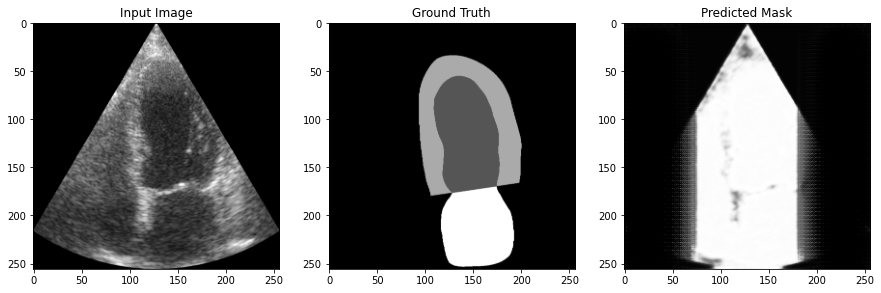

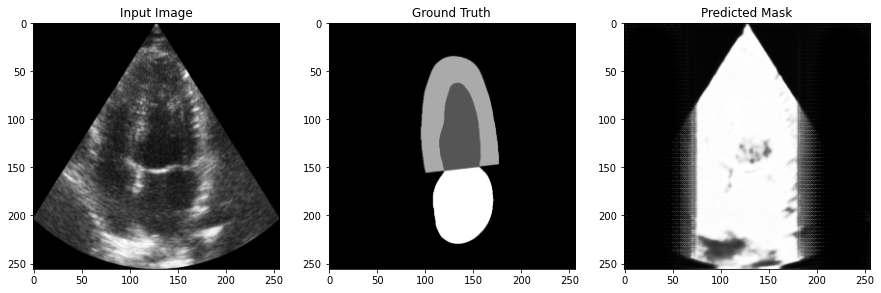

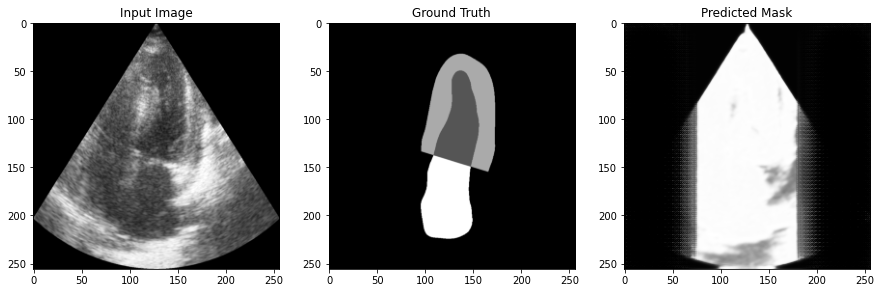

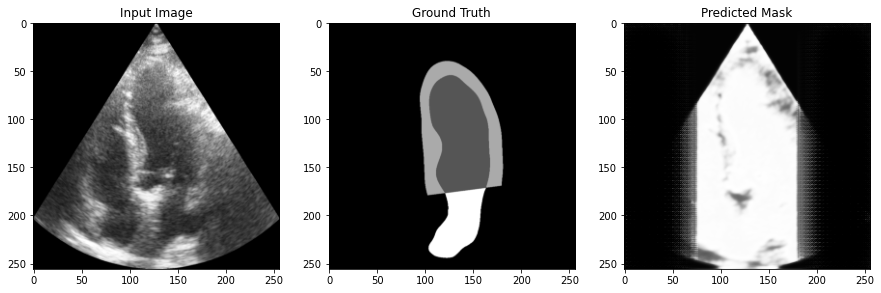

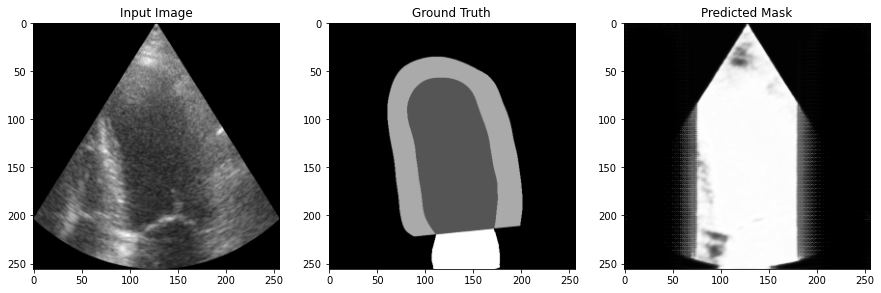

In [7]:
# Visualize some predictions
import matplotlib.pyplot as plt

def plot_predictions(X, y_true, y_pred, num_samples=5):
    indices = np.random.choice(len(X), num_samples)
    for i, idx in enumerate(indices):
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
        ax1.imshow(X[idx, :, :, 0], cmap='gray')
        ax1.set_title('Input Image')
        ax2.imshow(y_true[idx, :, :, 0], cmap='gray')
        ax2.set_title('Ground Truth')
        ax3.imshow(y_pred[idx, :, :, 0], cmap='gray')
        ax3.set_title('Predicted Mask')
        plt.show()

y_pred = model.predict(X_test)
plot_predictions(X_test, y_test, y_pred)

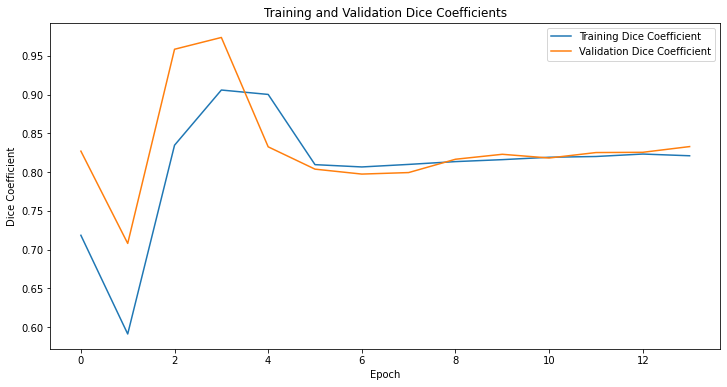

In [8]:
import matplotlib.pyplot as plt

# Plot training and validation Dice coefficients
plt.figure(figsize=(12, 6))
plt.plot(history.history['dice_coeff'], label='Training Dice Coefficient')
plt.plot(history.history['val_dice_coeff'], label='Validation Dice Coefficient')
plt.xlabel('Epoch')
plt.ylabel('Dice Coefficient')
plt.title('Training and Validation Dice Coefficients')
plt.legend()
plt.show()

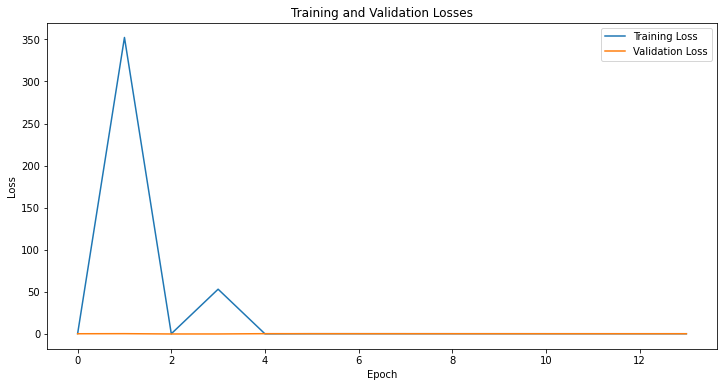

In [9]:
# Plot training and validation losses
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

6/6 [==============================] - 2s 412ms/step


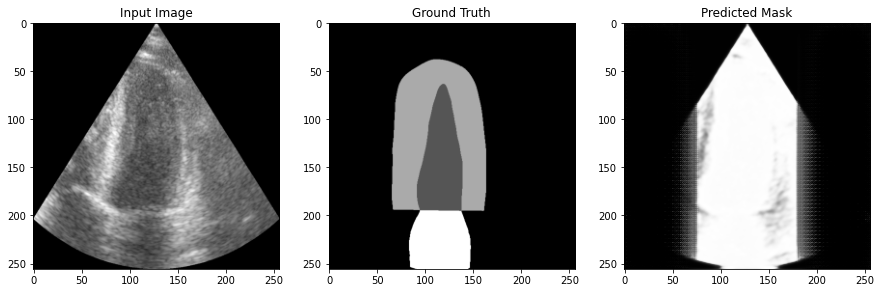

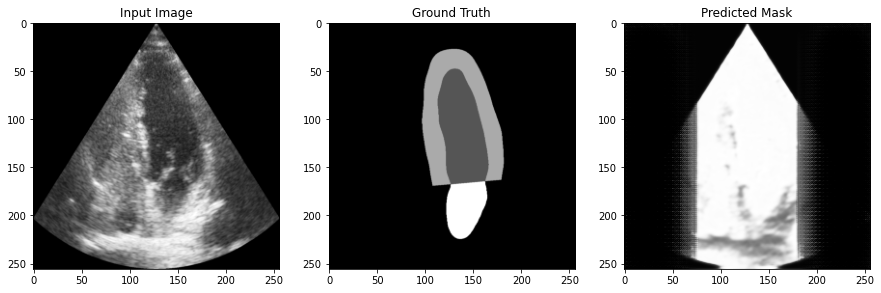

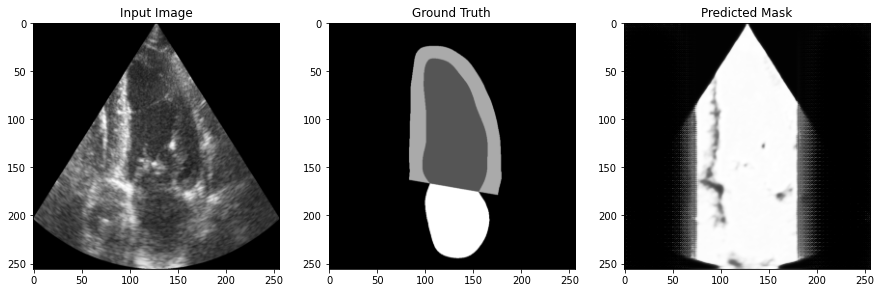

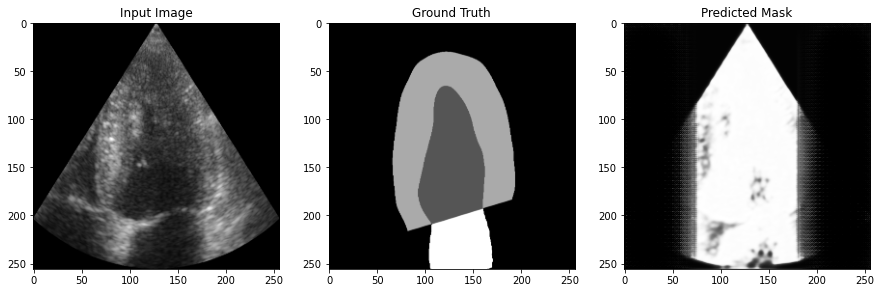

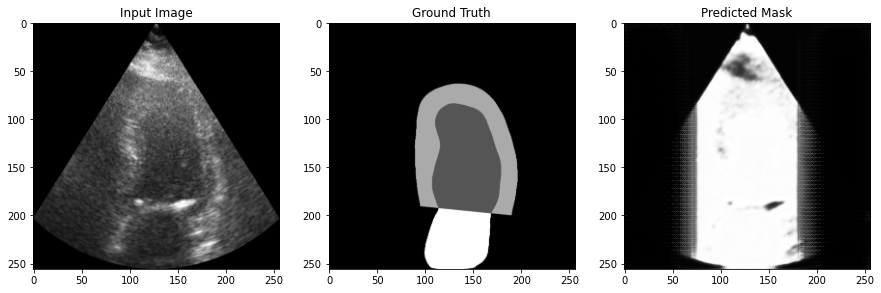

In [10]:
def plot_predictions(X, y_true, y_pred, num_samples=5):
    indices = np.random.choice(len(X), num_samples)
    for i, idx in enumerate(indices):
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
        ax1.imshow(X[idx, :, :, 0], cmap='gray')
        ax1.set_title('Input Image')
        ax2.imshow(y_true[idx, :, :, 0], cmap='gray')
        ax2.set_title('Ground Truth')
        ax3.imshow(y_pred[idx, :, :, 0], cmap='gray')
        ax3.set_title('Predicted Mask')
        plt.show()

y_pred = model.predict(X_test)
plot_predictions(X_test, y_test, y_pred)


6/6 [==============================] - 2s 406ms/step
Precision: 0.6390
Recall: 0.9212
F1-score: 0.7545


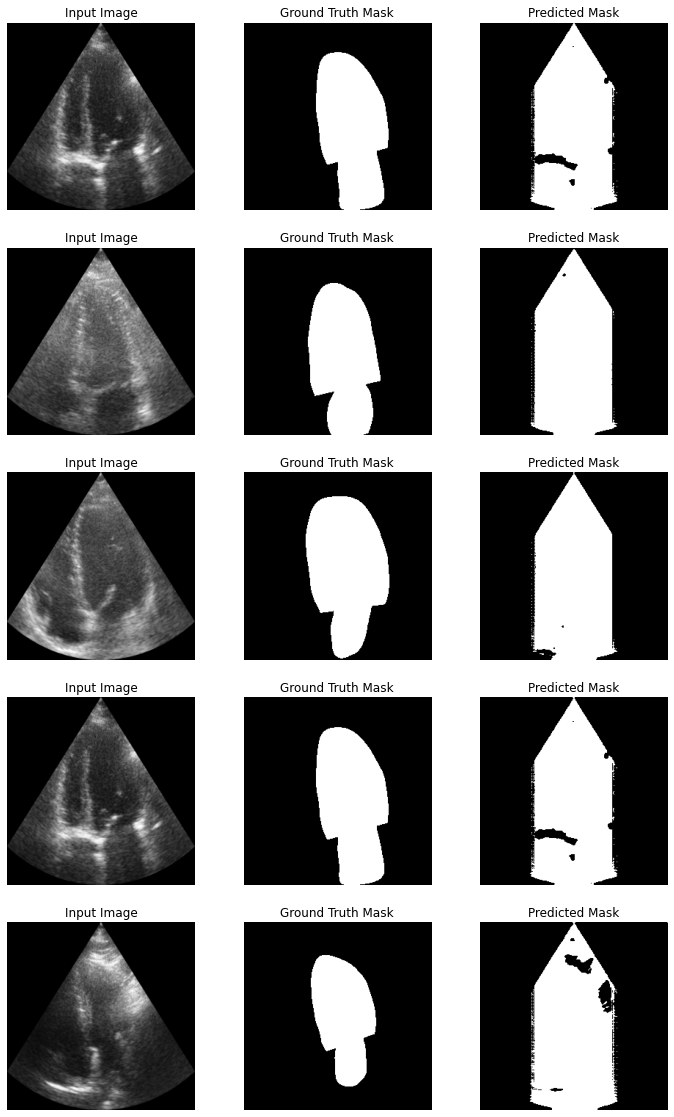

In [12]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

# Make predictions
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(np.uint8)
y_test_binary = (y_test > 0.5).astype(np.uint8)

# Calculate Precision, Recall, and F1-score
precision = precision_score(y_test_binary.flatten(), y_pred_binary.flatten())
recall = recall_score(y_test_binary.flatten(), y_pred_binary.flatten())
f1 = f1_score(y_test_binary.flatten(), y_pred_binary.flatten())

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

# Visualize a few examples
n_samples = 5
fig, axs = plt.subplots(n_samples, 3, figsize=(12, n_samples * 4))

for i in range(n_samples):
    sample_idx = np.random.randint(0, len(X_test))

    axs[i, 0].imshow(X_test[sample_idx], cmap='gray')
    axs[i, 0].set_title('Input Image')
    axs[i, 0].axis('off')

    axs[i, 1].imshow(y_test_binary[sample_idx].squeeze(), cmap='gray')
    axs[i, 1].set_title('Ground Truth Mask')
    axs[i, 1].axis('off')

    axs[i, 2].imshow(y_pred_binary[sample_idx].squeeze(), cmap='gray')
    axs[i, 2].set_title('Predicted Mask')
    axs[i, 2].axis('off')

plt.show()
